In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import scipy.stats as st
import statsmodels.api as sm
import scipy
from scipy.spatial import distance


Exercise 1


No handles with labels found to put in legend.
No handles with labels found to put in legend.


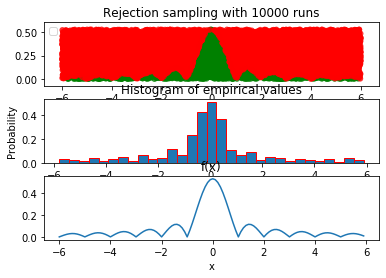

In [2]:
print("\nExercise 1")
r = 10000
A = 1.8988
resX = []
resY = []
for x in np.arange(-6, 6, 0.1):
    if x == 0:
        y = 1
    else:
        y = (1/A)*abs(math.sin(math.pi*x)/(math.pi*x))
    #print(x, y)
    resX.append(x)
    resY.append(y)

empX=[]
empY=[]
badX=[]
badY=[]
for run in range(r):
    x = random.uniform(-6, 6)
    y = random.uniform(0, 1)/A
    if x == 0:
        F = 1
    else:
        F = (1/A)*abs(math.sin(math.pi*x)/(math.pi*x))
    if y <= F:
        empX.append(x)
        empY.append(y)
    else:
        badX.append(x)
        badY.append(y)
emp = (empX, empY)
bad = (badX, badY)

data = (emp, bad)
# print("data:\n",data)
col = ("green", "red")

plt.subplot(3, 1, 1)
plt.title('Rejection sampling with {} runs'.format(r))
for data, color in zip(data, col):
    x, y = data
    plt.scatter(x, y, alpha=0.8, c=color, edgecolors='none')
    plt.xlabel("x")
    plt.legend(loc=2)

plt.subplot(3, 1, 2)
plt.title('Histogram of empirical values')
plt.hist(empX, density=True, bins=int(round(1+3.3*math.log(r), 0)), edgecolor='red')
plt.ylabel("Probability")
plt.xlabel("Samples")

plt.subplot(3, 1, 3)
plt.title('f(x)')
plt.plot(resX, resY)
plt.xlabel("x")
plt.show()


In [8]:
def CDFInversion(prob):
    U = random.uniform(0, 1)
    state = 0
    if U < sum(prob[:1]): state = 1   
    elif (sum(prob[:1])) <= U < (sum(prob[:2])): state = 2   
    elif (sum(prob[:2])) <= U < (sum(prob[:3])): state = 3   
    elif (sum(prob[:3])) <= U < (sum(prob[:4])): state = 4
        
    return state

def markovChain(P, iterations, counters):
    states_history = []
    stationary_probability_History = [[0],[0],[0],[0]] 
    startState = random.randrange(1, 4) 
    next_state = CDFInversion(P[random.randrange(1, 4) ])
    result = {}

    for i in range(1, iterations):
        states_history.append(next_state)
        counters[next_state-1] += 1
        stationary_probability_History[next_state-1].append(counters[next_state-1]/i)
        next_state = CDFInversion(P[next_state])
        
    for index, d in enumerate(counters):
        result[index + 1] = d / iterations
        
    return counters, result, states_history, stationary_probability_History

def plot_stationary_probability(subset):
    distrHist = pd.DataFrame(stationary_probability_History[0][:subset])
    distrHist[1] = pd.DataFrame(stationary_probability_History[1][:subset] )
    distrHist[2] = pd.DataFrame(stationary_probability_History[2][:subset] )
    distrHist[3] = pd.DataFrame(stationary_probability_History[3][:subset] )
    distrHist.columns = ['1','2','3','4']
    distrHist.plot()
    plt.show()
    
    return

def computeAvgThroughput(result, throughputs):
    res = np.sum(np.multiply(np.array(list(result.values())), throughputs))
    return res

    
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)

    return m, m-h, m+h

def plotAverageT():
    sph = []
    avg_throughput_list = []

    for i in range(0,100):
        sph.append( [ stationary_probability_History[0][i], stationary_probability_History[1][i], stationary_probability_History[2][i], stationary_probability_History[3][i] ] )
        dictATL = { j : sph[i][j] for j in range(0, 4) }

        for i in range(0,100):
            avg_throughput_list.append(computeAvgThroughput(dictATL, throughput_values))

    distrHist = pd.DataFrame(avg_throughput_list)
    distrHist.plot()
    plt.show()
    
    return avg_throughput_list

def drawRandomCoordinates(xi, yi, xj, yj, num=1000): 
    coordi = []
    coordj = []
    dist = []
    
    #Computing the Area Ai
    Xi = xi[1] - xi[0]
    Yi = yi[1] - yi[0]
    Xj = xj[1] - xj[0]
    Yj = yj[1] - yj[0]
    Ai = Xi * Yi  
    Aj = Xj * Yj    

    for i in range(num):
        x_i = random.uniform(xi[0], xi[1])
        y_i = random.uniform(yi[0], yi[1])
        x_j = random.uniform(xj[0], xj[1])
        y_j = random.uniform(yj[0], yj[1])
        coordi.append((x_i, y_i))
        coordj.append((x_j, y_j))
        
    for i in range(0, num): #Computing the distance of d_ij
        dist.append( distance.euclidean(coordi[i], coordj[i]) )
      
    return coordi, coordj, dist, Ai, Aj


def monteCarloIntegration(N, fadingDraws, coords_i, coords_j, theta, A_i, A_j):
    result = []
    for i in range(0, N):
        dist = distance.euclidean(coords_i[i], coords_j[i])
        rvs_exp = []

        for i in range(0, fadingDraws):
            U = random.uniform(0, 1)
            x = - (math.log(U) / 1)
            rvs_exp.append(x)  
        
        random_fadings = rvs_exp
        
        for i in range(0, len(random_fadings)):
            fading = random_fadings[i]       
            k = 2
            p_n = 3.2E-5  
            p_t = 5
            snr = (fading * p_t * pow(dist, -k)) / p_n
            
            if snr < theta:
                indicator = 1
            else:
                indicator = 0        
            
            tmp_p = (math.exp(-fading) / (A_i * A_j)) * indicator
            result.append(tmp_p)

    return np.sum(result) / len(result)


In [4]:
print("\nExercise 2.1-----------------------------------------------------\n")

n = 100000 #iterations 

P =  pd.DataFrame({ 1: [0.75   , 0.25,  0   ,  0   ],
                    2: [0.25   , 0.50,  0.25,  0   ],
                    3: [0      , 0.40,  0.40,  0.20],
                    4: [0      , 0   ,  0.25,  0.75]},
                    index=[1, 2, 3, 4])

stateCounter = [0,0,0,0]
stateCounter, result, history, stationary_probability_History = markovChain(P, n, stateCounter)

print(f"With {n} iterations the fractions of time that the Markov chain spend on : ")
print(f"\tState 1 was: {np.round(stateCounter[0] / n, 3)} (it was visited: {stateCounter[0]} times)")
print(f"\tState 2 was: {np.round(stateCounter[1] / n, 3)} (it was visited: {stateCounter[1]} times)")
print(f"\tState 3 was: {np.round(stateCounter[2] / n, 3)} (it was visited: {stateCounter[2]} times)")
print(f"\tState 4 was: {np.round(stateCounter[3] / n, 3)} (it was visited: {stateCounter[3]} times)")


Exercise 2.1-----------------------------------------------------

With 100000 iterations the fractions of time that the Markov chain spend on : 
	State 1 was: 0.325 (it was visited: 32478 times)
	State 2 was: 0.32 (it was visited: 31954 times)
	State 3 was: 0.2 (it was visited: 19997 times)
	State 4 was: 0.156 (it was visited: 15570 times)



Exercise 2.2--------------------------------------------------

Ploted the fractions computed in the previous point as a function of the number of steps:


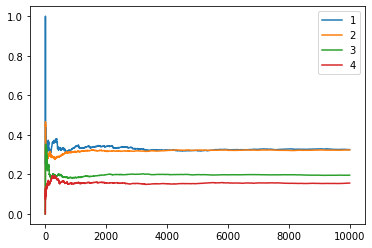

theoretical stationary probability distribution values:
 π1 = 0.32,  π2 = 0.32,  π3 = 0.20,  π4 = 0.16 

Computed values:
 π1 = 0.325,  π2 = 0.32,  π3 = 0.2, π4 = 0.156


In [5]:
print("\nExercise 2.2--------------------------------------------------\n")
print("Ploted the fractions computed in the previous point as a function of the number of steps:")

subset = 10000
plot_stationary_probability(subset)

print("theoretical stationary probability distribution values:\n π1 = 0.32,  π2 = 0.32,  π3 = 0.20,  π4 = 0.16 \n")
print(f"Computed values:\n π1 = {np.round(stateCounter[0]/n, 3)},  π2 = {np.round(stateCounter[1]/n, 3)},  π3 = {np.round(stateCounter[2]/n, 3)}, π4 = {np.round(stateCounter[3]/n, 3)}")


Exercise 2.3--------------------------------------------------



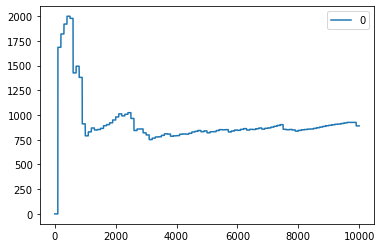

Average throughput modeled by the Markov chain: 864.5
and the 95% confidence interval is: [ 916.5 , 926.8 ] 

Plot of the average throughput against the number of state: 
Based on the throughput values (1500, 1000, 250, 50) for the given states the average throughput(864.5)Mb does make sence.


In [6]:
print("\nExercise 2.3--------------------------------------------------\n")

throughput_values = [1500, 1000, 250, 50]

avg_throughput = computeAvgThroughput(result, throughput_values)
avg_throughput_list = plotAverageT()
CI = mean_confidence_interval(avg_throughput_list)

print(f"Average throughput modeled by the Markov chain: {np.round(avg_throughput, 1)}" )
print(f"and the 95% confidence interval is: [ {np.round(CI[1], 1)} , {np.round(CI[2], 1)} ] " )
print(f"\nPlot of the average throughput against the number of state: " )
print(f"Based on the throughput values (1500, 1000, 250, 50) for the given states the average throughput({np.round(avg_throughput, 1)})Mb does make sence." )


Exercise 4.1 --------------------------------------

p = 1.45e-07 (for theta = 10)

The result of p for changing theta from 1 to 320:


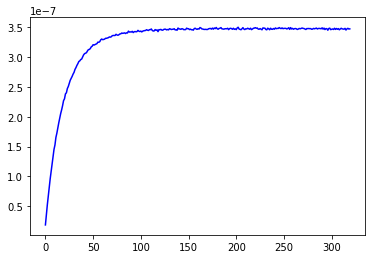

In [9]:
print("\nExercise 4.1 --------------------------------------\n")

n = 1000
fading_draws = 50
xi, yi, xj, yj = (0 ,20), (0 ,60), (60,80), (0,60)
theta = 10
probs_values = []

coordsi, coordsj, distm, A_i, A_j = drawRandomCoordinates(xi, yi, xj, yj, n)
p = monteCarloIntegration(n, fading_draws, coordsi, coordsj, theta, A_i, A_j)

for theta in range(1, 321):
    probs_values.append(monteCarloIntegration(n, fading_draws, coordsi, coordsj, theta, A_i, A_j))
    
print(f"p = {np.round(p, 10)} (for theta = 10)")
print("\nThe result of p for changing theta from 1 to 320:")

plt.plot(probs_values, 'b')
plt.show()


Exercise 4.2 --------------------------------------

After playing with the size of the areas where we draw the positions of i and j:
red: xi = (0 ,50), yi = (0 ,20), xj = (10,80), yj = (50,80)
blue: xi = (10 ,30), yi = (0 ,30), xj = (20,70), yj = (40,80)


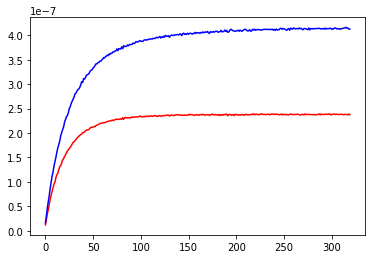


Increasing the number of realizations:
red: (node positions = 1000 and fading = 60)
blue: (node positions = 1000 and fading = 70)


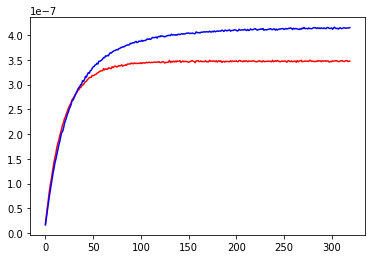


Deacraseing the number of realizations 
red: (node positions = 500 and fading = 40)
blue: (node positions = 200 and fading = 30)


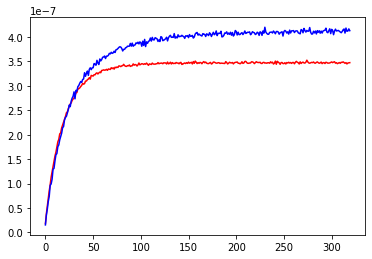


The amount of realizations needed for the results to be insensitive to an increase in the number of realizations:


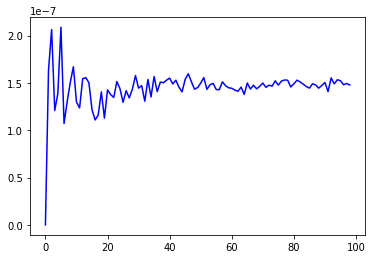

In [10]:
print("\nExercise 4.2 --------------------------------------")

coordsi, coordsj, dist, A_i, A_j = drawRandomCoordinates((0 ,50), (0 ,20), (10,80), (50,80), n)
probs_values = []
coordsi_2, coordsj_2, dist_2, A_i_2, A_j_2 = drawRandomCoordinates((10 ,30), (0 ,30), (20,70), (40,80), n)
probs_values_2 = []

for theta in range(1, 321):
    probs_values.append(monteCarloIntegration(n, fading_draws, coordsi, coordsj, theta, A_i, A_j))
    probs_values_2.append(monteCarloIntegration(n, fading_draws, coordsi_2, coordsj_2, theta, A_i_2, A_j_2))

print("\nAfter playing with the size of the areas where we draw the positions of i and j:")
print(f"red: xi = (0 ,50), yi = (0 ,20), xj = (10,80), yj = (50,80)")
print(f"blue: xi = (10 ,30), yi = (0 ,30), xj = (20,70), yj = (40,80)")

#plt.subplot(1, 2, 1)
plt.plot(probs_values, 'r')
#plt.subplot(1, 2, 2)
plt.plot(probs_values_2, 'b')
plt.show()

#------------------------------
n = 1000
n2 = 1000
fading_draws = 60
fading_draws_2 = 70
probs_values = []
probs_values_2 = []

coordsi, coordsj, distm, A_i, A_j = drawRandomCoordinates(xi, yi, xj, yj, n)

for theta in range(1, 321):
    probs_values.append(monteCarloIntegration(n, fading_draws, coordsi, coordsj, theta, A_i, A_j))
    probs_values_2.append(monteCarloIntegration(n2, fading_draws_2, coordsi_2, coordsj_2, theta, A_i_2, A_j_2))
    
print(f"\nIncreasing the number of realizations:")
print(f"red: (node positions = {n} and fading = {fading_draws})")
print(f"blue: (node positions = {n2} and fading = {fading_draws_2})")

#plt.subplot(1, 2, 1)
plt.plot(probs_values, 'r')
#plt.subplot(1, 2, 2)
plt.plot(probs_values_2, 'b')
plt.show()

#------------------------------
n = 500
n2 = 200
fading_draws = 40
fading_draws_2 = 30
probs_values = []
probs_values_2 = []

coordsi, coordsj, distm, A_i, A_j = drawRandomCoordinates(xi, yi, xj, yj, n)

for theta in range(1, 321):
    probs_values.append(monteCarloIntegration(n, fading_draws, coordsi, coordsj, theta, A_i, A_j))
    probs_values_2.append(monteCarloIntegration(n2, fading_draws_2, coordsi_2, coordsj_2, theta, A_i_2, A_j_2))

print(f"\nDeacraseing the number of realizations ")
print(f"red: (node positions = {n} and fading = {fading_draws})")
print(f"blue: (node positions = {n2} and fading = {fading_draws_2})")

#plt.subplot(1, 2, 1)
plt.plot(probs_values, 'r')
#plt.subplot(1, 2, 2)
plt.plot(probs_values_2, 'b')
plt.show()

#------------------------------
n = 1000
probs_values = []

for fd in range(1, 100):
    probs_values.append(monteCarloIntegration(fd, fd, coordsi, coordsj, 10, A_i, A_j))

print("\nThe amount of realizations needed for the results to be insensitive to an increase in the number of realizations:")

plt.plot(probs_values, 'b')
plt.show()